In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [6]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)
from liset_tk import liset_tk



c:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples
['c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\runSNN', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\utils', 'c:\\nrn\\lib\\python', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\liset_tk', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\setuptools\\_vendor

In [7]:
parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder

bandpass=[100,250]
freq=1000
WINDOW_SHIFT=119
WINDOW_SIZE=180
downsampled_fs = 1000 # Downsampled frequency
time_max=60
window_size=0.05
sample_ratio=0.75
scaling_factor=2
refractory=0

In [8]:
from signal_aid import most_active_channel, bandpass_filter


In [11]:
load=False


from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_data' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # Split the Input Data and Ground Truth into Windows
        windowed_input_data = []    # Input Data Windows
        windowed_gt = []        # Ground Truth Windows (spike time if HFO, -1 if no HFO)
        filtered_windows=[] 
        total_windows_count = 0
        skipped_hfo_count = 0   # Counts the nº of skipped HFOs due to no input activations
        total_hfos=0
        # curr_ripple_times = ripples_concat[curr_ripple_id]    # Get the GT times for the current sEEG source

        # LOAD THE DATA
        # Iterate over the datasets
        for dataset in os.listdir(parent):
            dataset_path = os.path.join(parent, dataset)
            liset= liset_tk(dataset_path, shank=3, downsample=1000, verbose=False)

            ripples=np.array(liset.ripples_GT)
            spikified=np.zeros((liset.data.shape[0], liset.data.shape[1], 2))
            filtered=np.zeros((liset.data.shape[0], liset.data.shape[1]))
            thresholds = np.zeros((liset.data.shape[1]))

            print("data shape: ", liset.data.shape)
            print("ripples shape: ", ripples.shape)
            # print("Head of data_concat: ", data[:10][:])
            # print("Head of ripples_concat: ", ripples[:10])
            ripples = ripples[np.argsort(ripples[:, 0])]
            # print(ripples[:10][:])

            for channel in range(liset.data.shape[1]):
                channel_signal = liset.data[:time_max*downsampled_fs, channel]
                filtered_signal=bandpass_filter(channel_signal, bandpass=bandpass, fs=liset.fs)
                thresholds[channel]=round(calculate_threshold(filtered_signal,downsampled_fs,window_size,sample_ratio,scaling_factor),4)

                if thresholds[channel] > 0.1:
                    channel_signal = liset.data[:, channel]
                    curr_ripple_id = 0     # Keep track of the current GT event index since it is monotonically increasing the timestep
                    filtered_liset=bandpass_filter(channel_signal, bandpass=bandpass, fs=liset.fs)
                    spikified[:, channel, :]=up_down_channel(filtered_liset,thresholds[channel],liset.fs,refractory)
                    
                    for i in range(0, liset.data.shape[0], WINDOW_SHIFT):
                        left, right = i, i+WINDOW_SIZE
                        # Get the current input window
                        curr_window = spikified[left:right, channel, :]
                        filtered_window = filtered_liset[left:right]
                        
                        # Increment the total windows count
                        total_windows_count += 1
                        # Check if the current window is smaller than the expected size
                        if curr_window.shape[0] < WINDOW_SIZE:
                            # If the current window is smaller than the expected size, break the loop
                            print(f"[WARNING] Current window [{left}, {right}] is smaller than the expected size. Breaking the loop...")
                            break

                        # OPTIMIZATION STEP: Skip windows with no activations - The gradient will be zero (at least when using MSE Spike Rate)
                        if np.sum(curr_window) == 0:
                            # print(f"Window [{left}:{right}] has no Input activations. Skipping...")
                            cur_gt_time=[-1, -1]    # Default value for Spike Time (no HFO)
                            if curr_ripple_id < ripples.shape[0]:
                                cur_gt_time = ripples[curr_ripple_id]    # Convert to closest integer (floor)
                            if (cur_gt_time[1] >= left) and (cur_gt_time[0] <= right):
                                if cur_gt_time[1] <= right:
                                    print(f"[WARNING] Window [{left}:{right}] has a GT event at {cur_gt_time} and NO Input activations. Skipping...")
                                    # Update the curr_gt_idx to the next GT event
                                    skipped_hfo_count += 1
                                curr_ripple_id += 1
                            continue   
                        
                        '''
                        Check if there is a GT event in the current window
                        '''

                        curr_gt = -1    # Default value for Spike Time (no HFO)
                        
                        # Check if the current GT event is within the current window
                        while curr_ripple_id<ripples.shape[0] and ripples[curr_ripple_id][1] < left:
                            # Ripple ends before the window starts → skip it
                            curr_ripple_id += 1
                        
                        if curr_ripple_id >= ripples.shape[0]:
                            curr_ripple_id=ripples.shape[0]-1
                    
                        cur_gt_time = ripples[curr_ripple_id]      
                        if (cur_gt_time[1] >= left) and (cur_gt_time[0] <= right):
                            '''
                                Check if the current window encapsulates the whole HFO Causality Window
                                The Network may spike in the interval [GT_time, GT_time + MEAN_HFO_DURATION + PRED_GT_TOLERANCE]
                                
                                However, we are using an upper limit for the HFO Duration of MAX_HFO_DURATION. This way, the Ground Truth
                                Timestamps will be clamped uppwards by WINDOW_SIZE - MAX_HFO_DURATION + MEAN_HFO_DURATION
                            '''
                            if cur_gt_time[1] <= right and cur_gt_time[0]>=left: # If the GT event is completely within the current window
                                '''The Network should predict the HFO -> Calculate the spike time
                                Let's assume the network should spike at the end of the relevant event. We have no way of knowing
                                the exact end time, so we use the mean duration of the event to calculate the spike time.
                                '''
                                avg_spike_time = cur_gt_time[0] + 31   # The network should spike at the end of the relevant event
                                
                                # Subtract the left offset to get the spike time in the current window
                                relative_spike_time = avg_spike_time - left
                                if relative_spike_time > WINDOW_SIZE:
                                    # If the spike time is greater than the window size, we want to skip the window
                                    print(f"[WARNING] Spike time {relative_spike_time} is greater than the window size {WINDOW_SIZE}. Adjusting...")
                                    relative_spike_time= cur_gt_time[1]-left

                                curr_gt = relative_spike_time   # Update the curr_gt value

                                # Update the curr_gt_idx to the next GT event
                                curr_ripple_id += 1
                                
                            elif cur_gt_time[1] > right or cur_gt_time[0] < left:
                                continue
                                # If the GT event is not completely within the current window, we want to skip the window
                        
                        # Append the current window    
                        windowed_input_data.append(curr_window)            
                        # Append the current GT Spike Time to the windowed GT
                        windowed_gt.append(curr_gt)
                        filtered_windows.append(filtered_window)
                    total_hfos+=ripples.shape[0]
                else:
                    print(f"[WARNING] Channel {channel} has a very low threshold. Skipping...")
        # Convert to numpy array
        filtered_windows=np.array(filtered_windows, dtype=np.float32)
        windowed_input_data = np.array(windowed_input_data)
        windowed_gt = np.array(windowed_gt, dtype=np.float32)
        removed_windows = total_windows_count - windowed_input_data.shape[0]
        print(f"Removed {removed_windows}/{total_windows_count} ({round((removed_windows / total_windows_count)*100, 2)}%) windows with no input activations")
        print(f"Skipped {skipped_hfo_count} HFOs due to no input activations")
        print(f"Total HFOs (theoretical): {total_hfos}")
else:
    print("Code Block already run. Skipping...")

print("Windowed Input Data Shape: ", windowed_input_data.shape)
print("Windowed GT Shape: ", windowed_gt.shape)
print("Filtered Windows Shape: ", filtered_windows.shape)



data shape:  (2398857, 8)
ripples shape:  (1309, 2)
[WARNING] Window [1547:1727] has a GT event at [1679 1719] and NO Input activations. Skipping...
[WARNING] Window [2023:2203] has a GT event at [2108 2139] and NO Input activations. Skipping...
[WARNING] Window [2142:2322] has a GT event at [2274 2316] and NO Input activations. Skipping...
[WARNING] Window [2618:2798] has a GT event at [2704 2731] and NO Input activations. Skipping...
[WARNING] Window [8806:8986] has a GT event at [8928 8961] and NO Input activations. Skipping...
[WARNING] Window [8925:9105] has a GT event at [9051 9097] and NO Input activations. Skipping...
[WARNING] Window [10710:10890] has a GT event at [10792 10821] and NO Input activations. Skipping...
[WARNING] Window [11424:11604] has a GT event at [11501 11544] and NO Input activations. Skipping...
[WARNING] Window [16779:16959] has a GT event at [16860 16897] and NO Input activations. Skipping...
[WARNING] Window [17612:17792] has a GT event at [17691 17725] 

In [8]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis

In [9]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")



GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([140979,     21,     25,      6,     27,      5,     18,     15,      5,     57,     37,
           17,     28,     23,     23,     49,     56,     46,     28,     67, ...,     44,     51,
           86,     57,     45,     29,     39,     50,     39,     43,     54,     54,     21,
           33,      8,     10,     28,     24,     22,      8], dtype=int64))
Number of windows with an HFO: 9812
Percentage of windows with an HFO: 6.51%


In [12]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [13]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts = hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts = np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts


In [14]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


In [15]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt, GT_HFO_MASK)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


NameError: name 'GT_HFO_MASK' is not defined

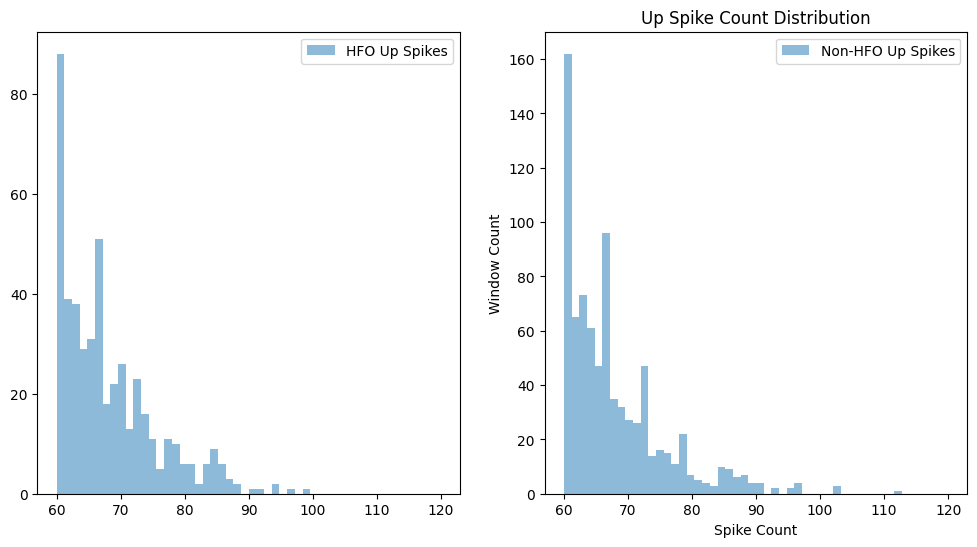

In [ ]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts, range=(60,120),bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, range=(60,120), bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

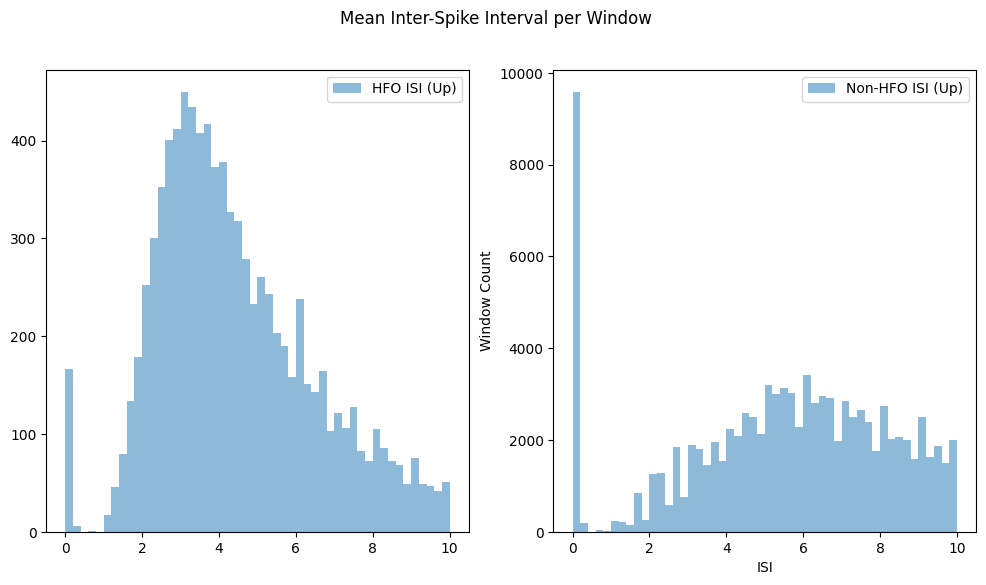

In [ ]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

In [16]:

# Histogram of up/down spike counts
plt.figure(figsize=(10,5))
plt.hist(up_spikes_per_window, bins=50, alpha=0.6, label='Up Spikes')
plt.hist(down_spikes_per_window, bins=50, alpha=0.6, label='Down Spikes')
plt.xlabel('Spike Count per Window')
plt.ylabel('Number of Windows')
plt.title('Spike Distribution Per Window')
plt.legend()
plt.show()

NameError: name 'up_spikes_per_window' is not defined

<Figure size 1000x500 with 0 Axes>

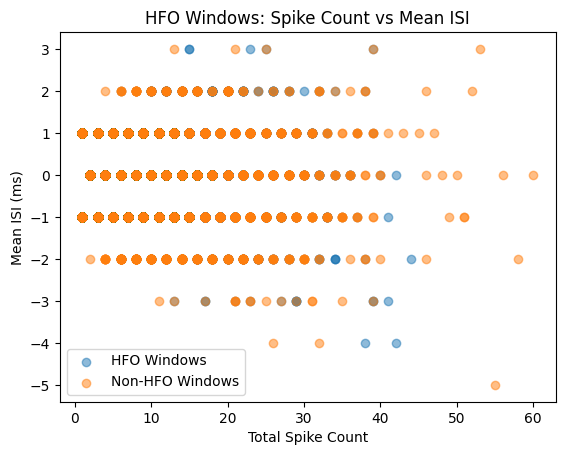

In [17]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Mean ISI (ms)')
plt.title('HFO Windows: Spike Count vs Mean ISI')
plt.legend()
plt.show()

In [18]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)

# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 4.678516228748068
Average HFO Down Counts: 4.688476730207797
Average Total HFO Counts: 9.366992958955864
Average Non-HFO Up Counts: 2.4328173141955363
Average Non-HFO Down Counts: 2.468625535432479
Average Total Non-HFO Counts: 4.901442849628015


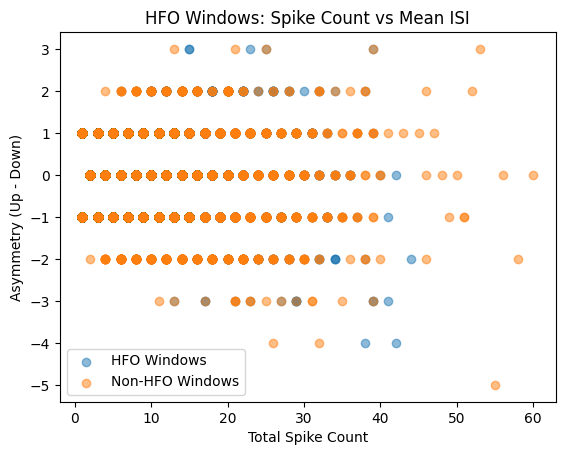

In [19]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Mean ISI')
plt.legend()
plt.show()

In [20]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
intermediate_sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[intermediate_sorted_indices]
sorted_gt= windowed_gt[intermediate_sorted_indices]
sorted_filtered_windows=filtered_windows[intermediate_sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"intermediate_sorted_indices: {intermediate_sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"intermediate_sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

intermediate_sorted_indices: [ 1958  3537  5275 ... 11348 19310 24478]
Sorted_data: (32437, 180, 2) | Sorted_gt: (32437,)| Sorted_filtered_windows: (32437, 180)
intermediate_sorted_gt preview: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
GT first window: -1.0 | GT last window: -1.0


In [21]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ -1.,  31.,  32.,  34.,  36.,  39.,  45.,  46.,  48.,  49.,  50.,
        51.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,
        75.,  76.,  77.,  78.,  80.,  81.,  82.,  83.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 114., 115., 116., 117., 118., 119., 120., 121., 122., 124.,
       125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146.,
       147., 148., 153., 154., 155., 159., 160., 161., 163., 164., 165.,
       167., 171., 173.], dtype=float32), array([503,   2,   2,   1,   1,   5,   3,   4,   2,   7,   6,   1,   4,
         2,   5,   3,   6,  10,   2,  15,   6,   5,   4,   3,   2,   4,
         3,   3,   2,   8,   5,   9,   6,   2,   3,  11,   

180


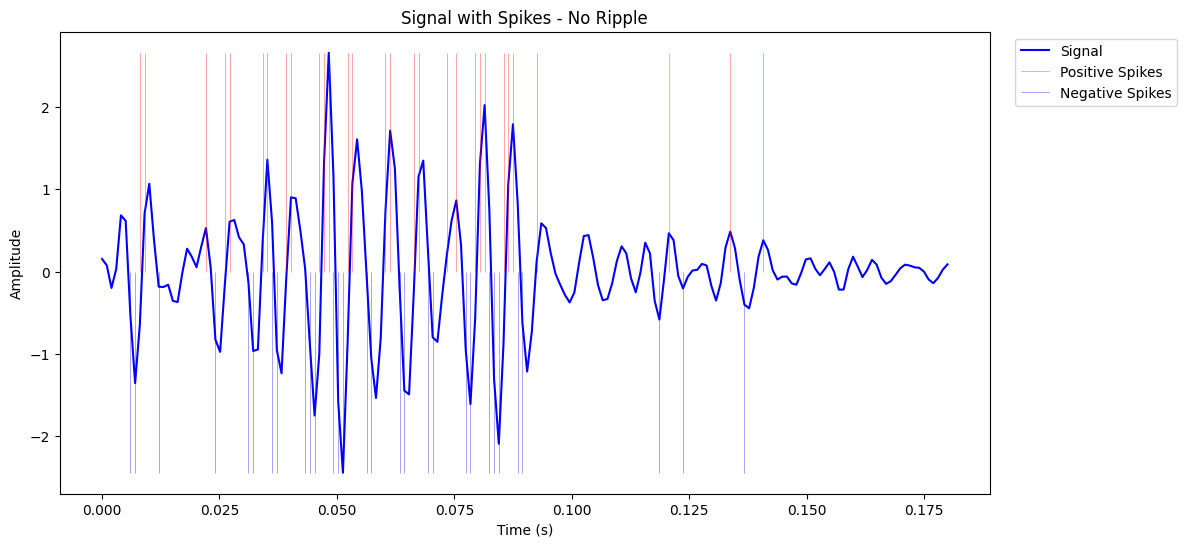

Total Spikes: 60.0
Up Spikes: 30.0
Down Spikes: 30.0


In [24]:
from snnTorch.utils.util import window_plot
window=0
plot_spikes=sorted_spikes[window,:,:]
plot_filtered_window=sorted_filtered_windows[window,:]
plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt, )
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [23]:
# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir)
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)